### env setup

In [17]:
from dotenv import load_dotenv
load_dotenv()

import os


# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [2]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
# like why again...

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
            # like why again
        ]
    )
    
    # like why again
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

- see the docs here for [ChatPromptTemplate](https://api.python.langchain.com/en/latest/_modules/langchain_core/prompts/chat.html#ChatPromptTemplate.partial)
```python
def partial(self, **kwargs: Any) -> ChatPromptTemplate:
        prompt_dict = self.__dict__.copy()
        prompt_dict["input_variables"] = list(
            set(self.input_variables).difference(kwargs)
        )
        prompt_dict["partial_variables"] = {**self.partial_variables, **kwargs}
        return type(self)(**prompt_dict)
```

- now let's deep dive into what `bind_tools`  (it's too much and unnecessary really)

`ChatOpenAI`
```python
 def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[
            Union[dict, str, Literal["auto", "none", "required", "any"], bool]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind tool-like objects to this chat model.

        Assumes model is compatible with OpenAI tool-calling API.

        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be  a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require the model to call.
                Options are:
                name of the tool (str): calls corresponding tool;
                "auto": automatically selects a tool (including no tool);
                "none": does not call a tool;
                "any" or "required": force at least one tool to be called;
                True: forces tool call (requires `tools` be length 1);
                False: no effect;

                or a dict of the form:
                {"type": "function", "function": {"name": <<tool_name>>}}.
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """

        formatted_tools = [convert_to_openai_tool(tool) for tool in tools]
        if tool_choice:
            if isinstance(tool_choice, str):
                # tool_choice is a tool/function name
                if tool_choice not in ("auto", "none", "any", "required"):
                    tool_choice = {
                        "type": "function",
                        "function": {"name": tool_choice},
                    }
                # 'any' is not natively supported by OpenAI API.
                # We support 'any' since other models use this instead of 'required'.
                if tool_choice == "any":
                    tool_choice = "required"
            elif isinstance(tool_choice, bool):
                if len(tools) > 1:
                    raise ValueError(
                        "tool_choice=True can only be used when a single tool is "
                        f"passed in, received {len(tools)} tools."
                    )
                tool_choice = {
                    "type": "function",
                    "function": {"name": formatted_tools[0]["function"]["name"]},
                }
            elif isinstance(tool_choice, dict):
                tool_names = [
                    formatted_tool["function"]["name"]
                    for formatted_tool in formatted_tools
                ]
                if not any(
                    tool_name == tool_choice["function"]["name"]
                    for tool_name in tool_names
                ):
                    raise ValueError(
                        f"Tool choice {tool_choice} was specified, but the only "
                        f"provided tools were {tool_names}."
                    )
            else:
                raise ValueError(
                    f"Unrecognized tool_choice type. Expected str, bool or dict. "
                    f"Received: {tool_choice}"
                )
            kwargs["tool_choice"] = tool_choice
        return super().bind(tools=formatted_tools, **kwargs)

```
```python
def convert_to_openai_tool(
    tool: Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool],
) -> Dict[str, Any]:
    """Convert a raw function/class to an OpenAI tool.

    Args:
        tool: Either a dictionary, a pydantic.BaseModel class, Python function, or
            BaseTool. If a dictionary is passed in, it is assumed to already be a valid
            OpenAI tool, OpenAI function, or a JSON schema with top-level 'title' and
            'description' keys specified.

    Returns:
        A dict version of the passed in tool which is compatible with the
            OpenAI tool-calling API.
    """
    if isinstance(tool, dict) and tool.get("type") == "function" and "function" in tool:
        return tool
    function = convert_to_openai_function(tool)
    return {"type": "function", "function": function}
    ```
    
```python
def convert_to_openai_function(
    function: Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool],
) -> Dict[str, Any]:
    """Convert a raw function/class to an OpenAI function.

    Args:
        function: Either a dictionary, a pydantic.BaseModel class, or a Python function.
            If a dictionary is passed in, it is assumed to already be a valid OpenAI
            function or a JSON schema with top-level 'title' and 'description' keys
            specified.

    Returns:
        A dict version of the passed in function which is compatible with the
            OpenAI function-calling API.
    """
    from langchain_core.tools import BaseTool

    # already in OpenAI function format
    if isinstance(function, dict) and all(
        k in function for k in ("name", "description", "parameters")
    ):
        return function
    # a JSON schema with title and description
    elif isinstance(function, dict) and all(
        k in function for k in ("title", "description", "properties")
    ):
        function = function.copy()
        return {
            "name": function.pop("title"),
            "description": function.pop("description"),
            "parameters": function,
        }
    elif isinstance(function, type) and issubclass(function, BaseModel):
        return cast(Dict, convert_pydantic_to_openai_function(function))
    elif isinstance(function, BaseTool):
        return cast(Dict, format_tool_to_openai_function(function))
    elif callable(function):
        return convert_python_function_to_openai_function(function)
    else:
        raise ValueError(
            f"Unsupported function\n\n{function}\n\nFunctions must be passed in"
            " as Dict, pydantic.BaseModel, or Callable. If they're a dict they must"
            " either be in OpenAI function format or valid JSON schema with top-level"
            " 'title' and 'description' keys."
        )
```

In [18]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [19]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

```markdown
Components
Sequence[BaseMessage]:

This part specifies that messages is a sequence (e.g., a list, tuple, etc.) of BaseMessage objects. BaseMessage is likely a class or type that represents individual messages.
Annotated[..., operator.add]:

Annotated is a way to attach additional metadata to a type. Here, the metadata is operator.add.
operator.add is a function from the operator module that represents addition. When used in this context, it typically means that sequences of messages can be combined using the addition operator (+). This suggests that you can concatenate or merge sequences of messages.
```

In [27]:
import functools
from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    print('Result:::')
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        
    print(result)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

what is `functools.partial`
```python
def partial(func, /, *args, **keywords):
    def newfunc(*fargs, **fkeywords):
        newkeywords = {**keywords, **fkeywords}
        return func(*args, *fargs, **newkeywords)
    newfunc.func = func
    newfunc.args = args
    newfunc.keywords = keywords
    return newfunc
```

In [34]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [35]:
# Either agent can decide to end
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [36]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

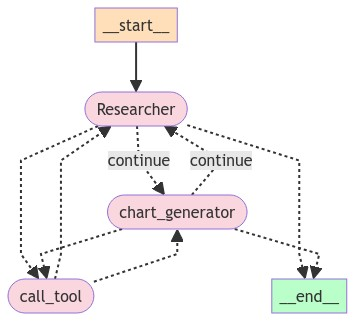

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Result:::
content='' additional_kwargs={'tool_calls': [{'id': 'call_F7fmUfrpOS6CNBO3mJ10692R', 'function': {'arguments': '{"query":"Singapore GDP by year"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 220, 'total_tokens': 241}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} name='Researcher' id='run-3ac01d68-13c5-4b4f-8ab2-99b4dfcc4189-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Singapore GDP by year'}, 'id': 'call_F7fmUfrpOS6CNBO3mJ10692R'}]
{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_F7fmUfrpOS6CNBO3mJ10692R', 'function': {'arguments': '{"query":"Singapore GDP by year"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 220, 'total_tokens': 241}, 'model_na

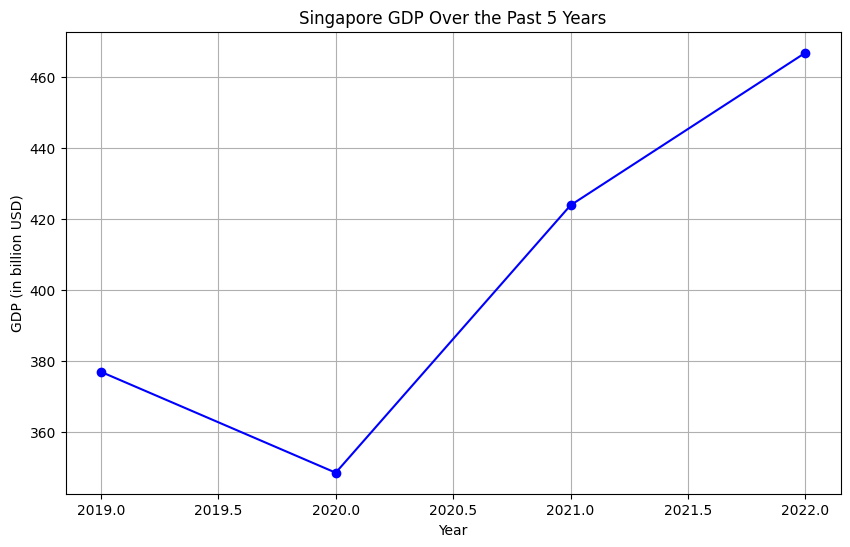

Result:::
content='' additional_kwargs={'tool_calls': [{'id': 'call_BNYh8aolwN5rPRGmsnHDtakB', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\nyears = [2022, 2021, 2020, 2019]\\ngdp_values = [466.79, 423.80, 348.39, 376.84]\\n\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\')\\nplt.title(\'Singapore GDP Over the Past 5 Years\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP (in billion USD)\')\\nplt.grid(True)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 1418, 'total_tokens': 1558}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} name='chart_generator' id='run-76186098-0145-455e-a8ed-5f164d0e7f93-0' tool_calls=[{'name': 'python_repl', 'args': {'code': "import matplotlib.pyplot as plt\n\nyears = [2022, 2021, 2020, 2019]\ngdp_values = [466.79, 423.80, 348.3

In [39]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
#                 content="Fetch the UK's GDP over the past 5 years,"
                content="Fetch Singapore's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")